In [2]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import numpy as np
from numpy.linalg import slogdet
import matplotlib.pyplot as plt
bempp.api.show_available_platforms_and_devices()
bempp.api.set_default_device(0, 0)

0: Portable Computing Language
    0: pthread-Intel(R) Xeon(R) W-2155 CPU @ 3.30GHz


In [3]:
grid = bempp.api.shapes.regular_sphere(3)
print(f"Number of elements: {grid.number_of_elements}")

Number of elements: 512


In [4]:
vert1 = grid.vertices.copy()
rows = vert1.shape[0]
cols = vert1.shape[1]

In [28]:
vert11 = np.zeros((rows,cols))
for i in range(cols):
    vert11[0,i] = -4

In [29]:
vert2 = vert1 + vert11

In [30]:
elets = grid.elements.copy()

In [31]:
verts = np.hstack([vert1,vert2])

In [32]:
elt = np.hstack([elets,elets+cols])

In [33]:
new_grid = grid = bempp.api.grid.grid.Grid(verts, elt)

ValueError: row index exceeds matrix dimensions

In [19]:
rwg1 = bempp.api.function_space(new_grid, "RWG", 0)
snc1 = bempp.api.function_space(new_grid, "SNC", 0)

In [20]:
wavenumber  = 1j*4
op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg1, snc1, wavenumber)

mat = np.real(op11.weak_form().A)
sign, logdet = slogdet(mat)
print(logdet)

-6179.749929727584


In [21]:
%matplotlib inline
from matplotlib import pyplot as plt

In [76]:
singular_part = bempp.api.operators.boundary.laplace.single_layer(space, space, space, assembler='only_singular_part').weak_form().A

root:INFO: Singular kernel runtime [ms]: 22.533212


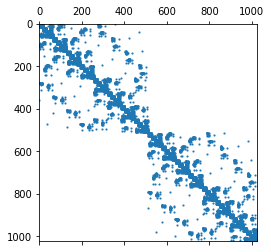

In [77]:
plt.spy(singular_part, markersize=1)

In [78]:
from bempp.api.grid.octree import Octree
tree = Octree(grid, maximum_level=2)

KeyError: 0

In [10]:
index_dict = tree.leaf_entities_by_morton_index
sorted_indices = []
for key in sorted(list(index_dict)):
    sorted_indices += index_dict[key]

In [11]:
sorted_singular_part = singular_part.todense()[:, sorted_indices][sorted_indices, :]

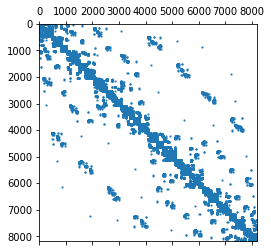

In [12]:
plt.spy(sorted_singular_part, markersize=1)

In [13]:
dims = [len(index_dict[key]) for key in index_dict]
print(dims)

[211, 123, 123, 211, 123, 211, 22, 211, 123, 123, 211, 123, 211, 22, 211, 123, 123, 211, 123, 211, 22, 211, 123, 123, 211, 123, 211, 22, 211, 123, 123, 211, 123, 211, 22, 211, 123, 123, 211, 123, 211, 22, 211, 123, 123, 211, 123, 211, 22, 211, 123, 123, 211, 123, 211, 22]


#### Construct the original matrix

In [14]:
sorted_mat = mat[:, sorted_indices][sorted_indices, :]

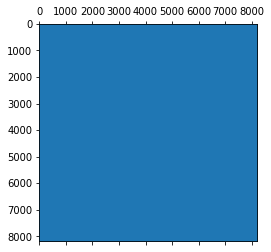

In [15]:
plt.spy(sorted_mat, markersize=1)

In [17]:
n = grid.number_of_elements
nboxes = 64
size = n // nboxes

In [18]:
def get_box(nx, ny, sorted_mat, nboxes, n):
    """Return the content of a given box"""
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return sorted_mat[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

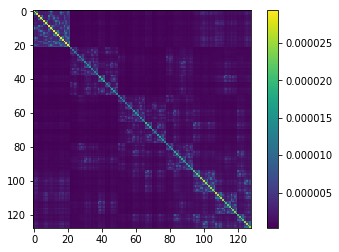

In [19]:
m1 = get_box(0,0,sorted_mat,nboxes,n)
plt.imshow(m1)
plt.colorbar()

In [20]:
def plot_box_ranks(sorted_mat, nboxes, n, tol=1E-8):
    """Plot rank of the boxes."""
    from scipy.linalg import svdvals
    ranks = np.zeros((nboxes,nboxes),dtype='int32')
    for i in range(nboxes):
        for j in range(nboxes):
            m = get_box(i, j, sorted_mat, nboxes, n)
            s = svdvals(m)
            ranks[i,j] = np.sum(s>tol)
    plt.imshow(ranks, cmap='Accent')
    plt.colorbar()

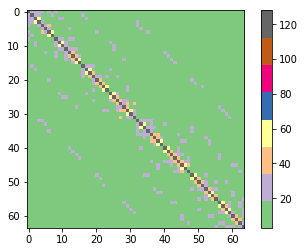

In [21]:
plot_box_ranks(sorted_mat,nboxes,n)

#### Return $A_{i}$, which is the combination of the $i$th off-diagonal block row and the transpose of the $i$th off-diagonal block column.

In [22]:
def get_con_box(i,sorted_mat,nboxes,n):
    BB = sorted_mat[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = np.transpose(sorted_mat[:, i * size : (i + 1) * size])
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

#### Return $L_{i}$ and $R_{j}$ inside of $A_{ij} = L_{i}S_{ij}R_{j}$, where $R_{j} = L_{j}^{T}$ and $A_{i} = L_{i}S_{i}V_{i}$. Also return the matrix S constructed by using the original matrix and the index set which is generated from computing $L_{i}$.
$S = 
\begin{bmatrix}
0 & S_{12} & S_{13} & \dots & S_{1N} \\
S_{21} & 0 & S_{23} & \dots & S_{2N} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
S_{N1} & S_{N2} & \dots & S_{N,N-1} & 0
\end{bmatrix}
$

In [23]:
def L(i,k,sorted_mat,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box(i,sorted_mat,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,sorted_mat,nboxes,n),k,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [24]:
def index_set(k,sorted_mat,nboxes,n):
    l = []
    for i in range(nboxes):
        l.append(L(i,k,sorted_mat,nboxes,n)[1][0:k])
    return l

In [25]:
def S(k,sorted_mat,nboxes,n):
    ll = index_set(k,sorted_mat,nboxes,n)
    mat = np.zeros((k*nboxes,k*nboxes))
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                mat_ =  get_box(i,j,sorted_mat,nboxes,n)[ll[i],:]
                mat[i*k:(i+1)*k,j*k:(j+1)*k] = mat_[:,ll[j]]
    return mat

In [26]:
def R(i,k,sorted_mat,nboxes,n):
    RR = np.transpose(L(i,k,sorted_mat,nboxes,n)[0])
    return RR

#### Construct the structured matrix and its LU decomposition
$\tilde{A} = 
\begin{bmatrix}
    D & L & 0 \\
    R & 0 & -I \\
    0 & -I & S
\end{bmatrix}
= \begin{bmatrix}
    I & 0 & 0 \\
    RD^{-1} & I & 0 \\
    0 & (RD^{-1}L)^{-1} & I
\end{bmatrix}  \begin{bmatrix}
    D & L & 0 \\
    0 & -RD^{-1}L & -I \\
    0 & 0 & S+(RD^{-1}L)^{-1}
\end{bmatrix}$

Then, we do the LU decomposition on each diagonal block's diagonal block (i.e. $A_{ii}$ and $-R_{i}A_{ii}^{-1}L_{i}$) of the upper triangular matrix. 
This is the new block LU decomposition and we can notice that the block upper triangular matrix is also an upper triangular matrix that we need. 

#### Construct the matrix $S+(RD^{-1}L)^{-1}$ first

In [27]:
def new_S(k,A,nboxes,n):
    mat_ = S(k,sorted_mat,nboxes,n)
    for i in range(nboxes):
        mat_[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R(i,k,sorted_mat,nboxes,n) @ np.linalg.inv(get_box(i,i,sorted_mat,nboxes,n)) @ L(i,k,sorted_mat,nboxes,n)[0])
    return mat_

#### Compute the log determinant of the structured matrix $\tilde{A}$

In [28]:
def logdet_method2(k,sorted_mat,nboxes,n):
    a1 = 0
    p1,l1,u1 = scipy.linalg.lu(new_S(k,sorted_mat,nboxes,n))
    for i in range(k*nboxes):
        a1 += math.log(abs(u1[i,i]))
        
    a2 = 0
    for i in range (nboxes):
        p2,l2,u2 = scipy.linalg.lu(get_box(i,i,sorted_mat,nboxes,n))
        for j in range(size):
            a2 +=math.log(abs(u2[j,j]))
            
    a3 = 0
    for i in range(nboxes):
        p3,l3,u3 = scipy.linalg.lu(-R(i,k,sorted_mat,nboxes,n)@np.linalg.inv(get_box(i,i,sorted_mat,nboxes,n)) @L(i,k,sorted_mat,nboxes,n)[0] )
        for j in range(k):
            a3 += math.log(abs(u3[j,j]))
    return a1 + a2 + a3

In [29]:
start_level_4_trial_1 = time.time()
print(logdet_method2(size,sorted_mat,nboxes,n))
end_level_4_trial_1 = time.time()
running_time_1 = end_level_4_trial_1-start_level_4_trial_1
print("When the size of the matrix is %g, the running time is %f if we set the rank k to be the same as the block size %g." %(n, running_time_1,size))

-94939.87741086342
When the size of the matrix is 8192, the running time is 130.925496 if we set the rank k to be the same as the block size 128.


In [67]:
def time_logdet(k,sorted_mat,nboxes,n):
    start_time = time.time()
    a = logdet_method2(k,sorted_mat,nboxes,n)
    end_time = time.time()
    b = end_time - start_time
    return b

#### Level 4 time

In [29]:
l_time = []
for i in range(1,size+1):
    l_time.append(time_logdet(i,sorted_mat,nboxes,n))

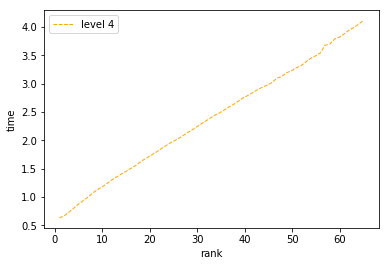

In [41]:
k_time = np.linspace(1,size+1,size)


plt.plot(k_time,l_time,color='orange',linewidth=1.0,linestyle='--')
plt.legend(['level 4'])

plt.ylabel('time')
plt.xlabel('rank')
plt.show()

#### Level 3 time

In [68]:
l_time3 = []
for i in range(1,size+1):
    l_time3.append(time_logdet(i,sorted_mat,nboxes,n))

#### Level 5 time

In [ ]:
l_time5 = []
for i in range(1,size+1):
    l_time5.append(time_logdet(i,sorted_mat,nboxes,n))

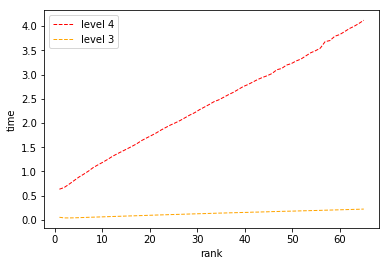

In [122]:
k_time = np.linspace(1,size+1,size)


plt.plot(k_time,l_time,color='red',linewidth=1.0,linestyle='--')
plt.plot(k_time,l_time3,color='orange',linewidth=1.0,linestyle='--')

plt.legend(['level 4','level 3'])

plt.ylabel('time')
plt.xlabel('rank')
plt.show()

#### Compute the log determinant of the original matrix

#### Level 4 exact value

In [99]:
P4,L4,U4 = scipy.linalg.lu(sorted_mat)

logdet4 = 0
for i in range(n):
    logdet4 += math.log(U4[i,i])
    
l4_det_exact = []
for i in range(size):
    l4_det_exact.append(logdet4)

#### Level 3 exact value

In [116]:
P3,L3,U3 = scipy.linalg.lu(sorted_mat)

logdet3 = 0
for i in range(n):
    logdet3 += math.log(U3[i,i])
l3_det_exact = []
for i in range(size):
    l3_det_exact.append(logdet3)

#### Level 5 exact value

In [ ]:
P5,L5,U5 = scipy.linalg.lu(sorted_mat)

logdet5 = 0
for i in range(n):
    logdet5 += math.log(U5[i,i])
l5_det_exact = []
for i in range(size):
    l5_det_exact.append(logdet5)

#### Level 3 approximated value

In [117]:
l3_det = []
for i in range(1,size+1):
    l3_det.append(logdet_method2(i,sorted_mat,nboxes,n))

#### Level 4 approximated value

In [100]:
l4_det = []
for i in range(1,size+1):
    l4_det.append(logdet_method2(i,sorted_mat,nboxes,n))

#### Level 5 approximated value

In [34]:
l5_det = []
for i in range(1,size+1):
    l5_det.append(logdet_method2(i,sorted_mat,nboxes,n))

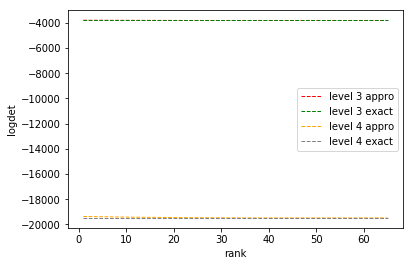

In [125]:
k_det = np.linspace(1,size+1,size)

plt.plot(k_det,l3_det,color='red',linewidth=1.0,linestyle='--')
plt.plot(k_det,l3_det_exact,color='green',linewidth=1.0,linestyle='--')
plt.plot(k_det,l4_det,color='orange',linewidth=1.0,linestyle='--')
plt.plot(k_det,l4_det_exact,color='grey',linewidth=1.0,linestyle='--')

plt.legend(['level 3 appro','level 3 exact','level 4 appro','level 4 exact'])

plt.ylabel('logdet')
plt.xlabel('rank')
plt.show()

#### Level 3 relative error

In [119]:
relative_error3 = []
for i in range(size):
    a = abs((l3_det[i] - logdet3)/logdet3)
    relative_error3.append(np.log10(a))

#### Level 4 relative error

In [101]:
relative_error4 = []
for i in range(size):
    a = abs((l4_det[i] - logdet4)/logdet4)
    relative_error4.append(np.log10(a))

#### Level 5 relative error

In [37]:
relative_error5 = []
for i in range(size):
    a = abs((l5_det[i] - logdet5)/logdet5)
    relative_error5.append(np.log10(a))

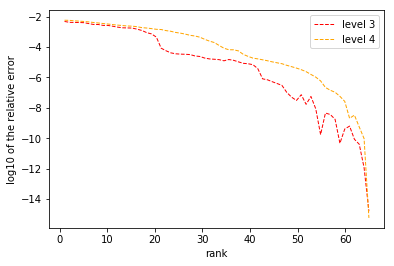

In [124]:
k_det = np.linspace(1,size+1,size)

plt.plot(k_det,relative_error3,color='red',linewidth=1.0,linestyle='--')
plt.plot(k_det,relative_error4,color='orange',linewidth=1.0,linestyle='--')


plt.legend(['level 3', 'level 4'])

plt.ylabel('log10 of the relative error')
plt.xlabel('rank')
plt.show()